In [1]:
import numpy as np
import os
import pandas as pd
# import accelerate
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
from tqdm import tqdm

## 前処理

In [2]:
data_dir = '/mount/nfs6/keigo-tada/yu_takagi_pro/preproc_annotation'

In [3]:
#BigBangTheory1_run1のobjectアノテーションについて前処理
bigban_run1_obj_en = os.path.join(data_dir, 'BigBangTheory1_run1_objectiveAnnot50chara_each1sec_en.txt')
bigban_run1_obj_ja = os.path.join(data_dir, 'BigBangTheory1_run1_objectiveAnnot50chara_each1sec.txt')

In [4]:
#英語アノテーションをアノテータごとに分割
with open(bigban_run1_obj_en, 'r', encoding='utf-8') as file:
    lines = file.readlines()

bigban_run1_obj_en_anno0 = []
bigban_run1_obj_en_anno1 = []
bigban_run1_obj_en_anno2 = []
bigban_run1_obj_en_anno3 = []
bigban_run1_obj_en_anno4 = []
for line in lines:
    line = line.replace('\n', '').split('\t')
    for i in range(len(line)):
        if i == 0:
            bigban_run1_obj_en_anno0.append(line[i])
        if i == 1:
            bigban_run1_obj_en_anno1.append(line[i])
        if i == 2:
            bigban_run1_obj_en_anno2.append(line[i])
        if i == 3:
            bigban_run1_obj_en_anno3.append(line[i])
        if i == 4:
            bigban_run1_obj_en_anno4.append(line[i])
#アノテータ番号の削除
bigban_run1_obj_en_anno0 = bigban_run1_obj_en_anno0[1:]
bigban_run1_obj_en_anno1 = bigban_run1_obj_en_anno1[1:]
bigban_run1_obj_en_anno2 = bigban_run1_obj_en_anno2[1:]
bigban_run1_obj_en_anno3 = bigban_run1_obj_en_anno3[1:]
bigban_run1_obj_en_anno4 = bigban_run1_obj_en_anno4[1:]
# # 結果
# print(bigban_run1_obj_en_ano0)

In [5]:
#日本語アノテーションをアノテータごとに分割
with open(bigban_run1_obj_ja, 'r', encoding='utf-8') as file:
    lines = file.readlines()

bigban_run1_obj_ja_anno0 = []
bigban_run1_obj_ja_anno1 = []
bigban_run1_obj_ja_anno2 = []
bigban_run1_obj_ja_anno3 = []
bigban_run1_obj_ja_anno4 = []
for line in lines:
    line = line.replace('\n','').replace('aaa','').split('/')
    for i in range(len(line)):
        if i == 0:
            bigban_run1_obj_ja_anno0.append(line[i][8:])
        if i == 1:
            bigban_run1_obj_ja_anno1.append(line[i])
        if i == 2:
            bigban_run1_obj_ja_anno2.append(line[i])
        if i == 3:
            bigban_run1_obj_ja_anno3.append(line[i])
        if i == 4:
            bigban_run1_obj_ja_anno4.append(line[i])
# #結果
# print(bigban_run1_obj_ja_anno0)

## embbedingsの取得

In [6]:
#このパラメータでどのアノテータか選べばあとは動きます
bigban_run1_obj_ja_anno = bigban_run1_obj_ja_anno0 #パラメータ ['bigban_run1_obj_ja_anno0', 'bigban_run1_obj_ja_anno1', 'bigban_run1_obj_ja_anno2', 'bigban_run1_obj_ja_anno3', 'bigban_run1_obj_ja_anno4']
bigban_run1_obj_en_anno = bigban_run1_obj_en_anno0 #パラメータ ['bigban_run1_obj_en_anno0', 'bigban_run1_obj_en_anno1', 'bigban_run1_obj_en_anno2', 'bigban_run1_obj_en_anno3', 'bigban_run1_obj_en_anno4']

In [7]:
#トーカナイザーとモデルの読み込み
tokenizer = AutoTokenizer.from_pretrained("llm-jp/llm-jp-13b-v2.0")
model = AutoModelForCausalLM.from_pretrained("llm-jp/llm-jp-13b-v2.0", torch_dtype=torch.bfloat16)
device = torch.device('cuda')
model.to(device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(97024, 5120, padding_idx=4)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
 

In [8]:
def batch_inference(texts, tokenizer, model, device, batch_size, max_length):
    """
    テキストをバッチサイズごとに処理し、embeddingsを生成する関数
    """
    embeddings = []
    num_texts = len(texts)
    print(f"Total number of texts: {num_texts}")
    
    for i in range(0, num_texts, batch_size):
        batch_texts = texts[i:i + batch_size]
        print(f"Processing batch {i // batch_size + 1} with {len(batch_texts)} texts")
        
        # トークナイズ
        prompts = tokenizer(batch_texts, return_tensors="pt", padding='max_length', truncation=True, max_length=max_length)
        prompts_ids = prompts.input_ids.to(device)

        # # トークナイズされたデータの形状を確認
        # print(f"Shape of tokenized input_ids: {prompts_ids.shape}")
        
        with torch.no_grad():  # 勾配計算を無効化してメモリ使用量を削減
            outputs = model(prompts_ids, output_hidden_states=True)
            embs = outputs.hidden_states

        # # 出力の形状を確認
        # print(f"Shape of hidden_states[0]: {embs[0].shape}")
        
        # バッチごとの埋め込みをリストに追加
        for j in range(prompts_ids.size(0)):
            emb_layers = []
            for emb in embs:
                emb_layers.append(emb[j].float().cpu().detach().numpy())  # float32にキャストしてからnumpyに変換
            embeddings.append(emb_layers)
        
        # メモリ解放
        del prompts_ids, outputs, embs
        torch.cuda.empty_cache()
    
    return embeddings

In [9]:
# embeddings生成
embeddings_ja = batch_inference(bigban_run1_obj_ja_anno, tokenizer, model, 'cuda', batch_size=150, max_length=65)
embeddings_en = batch_inference(bigban_run1_obj_en_anno, tokenizer, model, 'cuda', batch_size=150, max_length=65)

Total number of texts: 747
Processing batch 1 with 150 texts
Processing batch 2 with 150 texts
Processing batch 3 with 150 texts
Processing batch 4 with 150 texts
Processing batch 5 with 147 texts
Total number of texts: 747
Processing batch 1 with 150 texts
Processing batch 2 with 150 texts
Processing batch 3 with 150 texts
Processing batch 4 with 150 texts
Processing batch 5 with 147 texts


In [10]:
# print(model.config)

In [11]:
# # 結果の表示
# print(f"Total number of embeddings_ja: {len(embeddings_ja)}")
# for idx, emb in enumerate(embeddings_ja):  
#     print(f"Embedding_ja for text {idx + 1}: {emb[5].shape}")

In [12]:
# # 結果の表示
# print(f"Total number of embeddings_en: {len(embeddings_en)}")
# for idx, emb in enumerate(embeddings_en):  
#     print(f"Embedding_en for text {idx + 1}: {emb[5].shape}")

## 解析

In [13]:
def flatten_embeddings(embeddings):
    """
    各埋め込みベクトルをフラット化する関数
    """
    flattened = []
    for emb in tqdm(embeddings):
        flattened_layer = []
        for layer in emb:
            flattened_layer.append(layer.flatten())
        flattened.append(flattened_layer)
    return flattened

def calculate_layerwise_correlations(embeddings_ja, embeddings_en):
    """
    層ごとの埋め込みベクトルの相関係数を計算する関数
    """
    num_layers = len(embeddings_ja[0])
    correlations = []

    # フラット化された埋め込みベクトル
    embeddings_ja_flat = flatten_embeddings(embeddings_ja)
    embeddings_en_flat = flatten_embeddings(embeddings_en)

    for layer_idx in tqdm(range(num_layers)):
        layer_ja = np.array([emb[layer_idx] for emb in embeddings_ja_flat])
        layer_en = np.array([emb[layer_idx] for emb in embeddings_en_flat])
        
        # 各層の全テキストについての平均ベクトルを計算
        mean_ja = np.mean(layer_ja, axis=0)
        mean_en = np.mean(layer_en, axis=0)
        
        # 平均ベクトルの相関係数を計算
        correlation = np.corrcoef(mean_ja, mean_en)[0, 1]
        correlations.append(correlation)

    return correlations

In [14]:
# 相関係数の計算
layerwise_correlations = calculate_layerwise_correlations(embeddings_ja, embeddings_en)

# # 結果の表示
# for layer_idx, correlation in enumerate(layerwise_correlations):
#     print(f"Layer {layer_idx + 1} correlation: {correlation:.4f}")

100%|███████████████████████████████████████████| 41/41 [00:16<00:00,  2.55it/s]


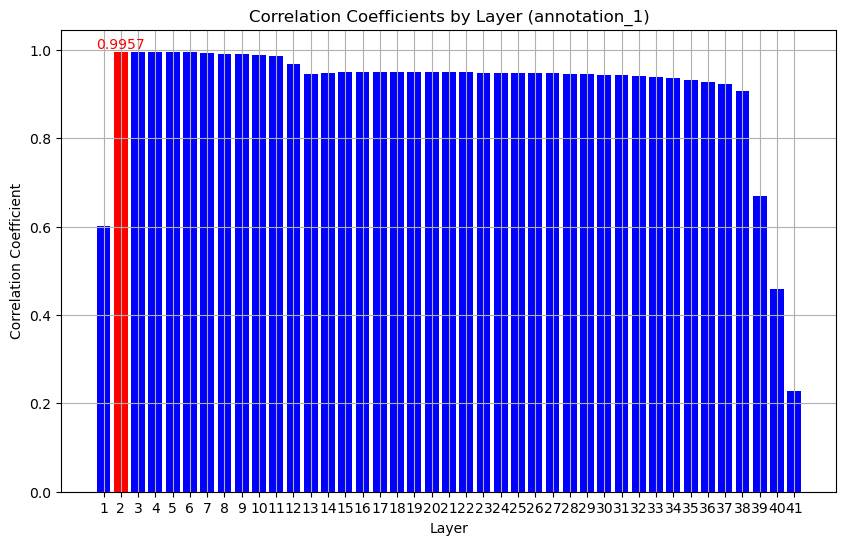

In [15]:
# 最大の相関係数を持つインデックスを特定
max_corr_idx = np.argmax(layerwise_correlations)
max_corr_value = layerwise_correlations[max_corr_idx]

# 棒グラフの色を設定
colors = ['b' if i != max_corr_idx else 'r' for i in range(len(layerwise_correlations))]

# 棒グラフの描画
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, len(layerwise_correlations) + 1), layerwise_correlations, color=colors)
plt.xlabel('Layer')
plt.ylabel('Correlation Coefficient')
plt.title(f'Correlation Coefficients by Layer (annotation_)')
plt.xticks(range(1, len(layerwise_correlations) + 1))
plt.grid(True)

# 最大の相関係数の棒の上に値を表示
plt.text(max_corr_idx + 1, max_corr_value, f'{max_corr_value:.4f}', ha='center', va='bottom', color='red')

plt.show()